# AutoEncoder for MNIST

In [4]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import random 
import os 

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE

## 參數設定

In [5]:
PATH_DATASETS = "" # 預設路徑
BATCH_SIZE = 256  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 載入 MNIST 手寫阿拉伯數字資料

In [6]:
train_ds = torchvision.datasets.MNIST(PATH_DATASETS, train=True, download=True)
test_ds  = torchvision.datasets.MNIST(PATH_DATASETS, train=False, download=True)

## 顯示 MNIST 圖像

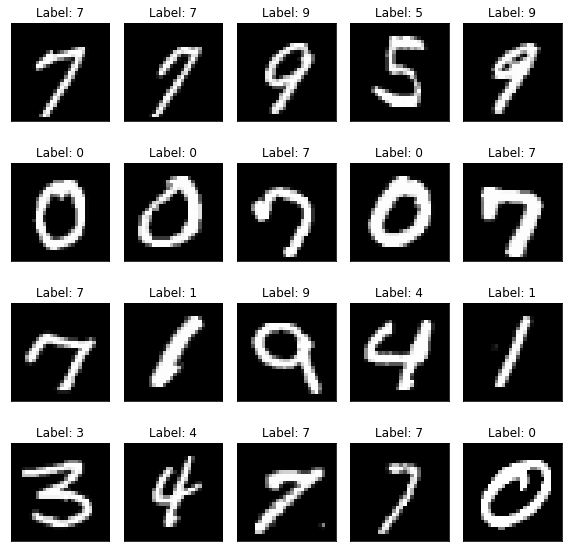

In [7]:
fig, axs = plt.subplots(4, 5, figsize=(8,8))
for ax in axs.flatten():
    # 隨機抽樣
    img, label = random.choice(train_ds)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## 建立 DataLoader

In [8]:
# 轉為張量
train_ds.transform = transforms.ToTensor()
test_ds.transform = transforms.ToTensor()

# 切割20%訓練資料作為驗證資料
m=len(train_ds) # 總筆數
train_data, val_data = random_split(train_ds, [int(m-m*0.2), int(m*0.2)])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE,shuffle=True)

## 定義模型，含 Encoder and Decoder 

In [9]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        # Convolution
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten(start_dim=1)

        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
        )
        
        self.encFC1 = nn.Linear(128, encoded_space_dim)
        self.encFC2 = nn.Linear(128, encoded_space_dim)
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar

##  定義抽樣函數

In [10]:
def resample(mu, logVar):
    std = torch.exp(logVar/2)  
    eps = torch.randn_like(std) # N(0, 1) 抽樣
    return mu + std * eps

##  定義解碼器

In [11]:
class Decoder(nn.Module):    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            # 反卷積
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

## 建立模型

In [12]:
# 固定隨機亂數種子，以利掌握執行結果
torch.manual_seed(0)

# encoder 輸出個數、decoder 輸入個數
d = 4
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128).to(device)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128).to(device)

## 定義損失函數及優化器

In [13]:
# KL divergence
def loss_fn(out, imgs, mu, logVar):
    kl_divergence = 0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
    return F.binary_cross_entropy(out, imgs, size_average=False) - kl_divergence

lr= 0.001 # Learning rate

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr)

## 定義加雜訊(Noise)的函數

In [14]:
def add_noise(inputs,noise_factor=0.3):
    noise = inputs+torch.randn_like(inputs)*noise_factor
    noise = torch.clip(noise,0.,1.)
    return noise

## 定義訓練函數

In [15]:
def train_epoch_den(encoder, decoder, device, dataloader, 
                    loss_fn, optimizer,noise_factor=0.3):
    # 指定為訓練階段
    encoder.train()
    decoder.train()
    train_loss = []
    # 訓練
    for image_batch, _ in dataloader:
        # 加雜訊
        image_noisy = add_noise(image_batch,noise_factor)
        image_noisy = image_noisy.to(device)    
        # 編碼
        mu, logVar = encoder(image_noisy)
        encoded_data = resample(mu, logVar)
        # 解碼
        decoded_data = decoder(encoded_data)
        # 計算損失
        loss = loss_fn(decoded_data, image_noisy, mu, logVar)

        # 反向傳導
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(f'損失：{loss.data}')
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

## 定義測試函數

In [16]:
def test_epoch_den(encoder, decoder, device, dataloader, 
                   loss_fn,noise_factor=0.3):
    # 指定為評估階段
    encoder.eval()
    decoder.eval()
    val_loss=0.0
    with torch.no_grad(): # No need to track the gradients
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # 加雜訊
            image_noisy = add_noise(image_batch,noise_factor)
            image_noisy = image_noisy.to(device)
            # 編碼
            mu, logVar = encoder(image_noisy)
            encoded_data = resample(mu, logVar)
            # 解碼
            decoded_data = decoder(encoded_data)
            # 輸出存入 conc_out 變數
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
            val_loss +=  loss_fn(decoded_data.cpu(), image_batch.cpu(), mu, logVar)
        # 合併
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # 驗證資料的損失
    return val_loss.data

## 定義重建圖像的函數

In [17]:
# fix 中文亂碼 
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 微軟正黑體
plt.rcParams['axes.unicode_minus'] = False

def plot_ae_outputs_den(epoch,encoder,decoder,n=5,noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(3,n,i+1)
        img = test_ds[i][0].unsqueeze(0)
        image_noisy = add_noise(img,noise_factor)     
        image_noisy = image_noisy.to(device)

        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img  = decoder(resample(*encoder(image_noisy)))

        if epoch == 0:
            plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == n//2:
                ax.set_title('原圖')
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == n//2:
                ax.set_title('加雜訊')

        if epoch == 0: 
            ax = plt.subplot(3, n, i + 1 + n + n)
        else: 
            ax = plt.subplot(1, n, i + 1)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if epoch == 0 and i == n//2:
            ax.set_title('重建圖像')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   

## 訓練

f:\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


EPOCH 1/50 	 訓練損失：125893.594 	 驗證損失： 3854028.000


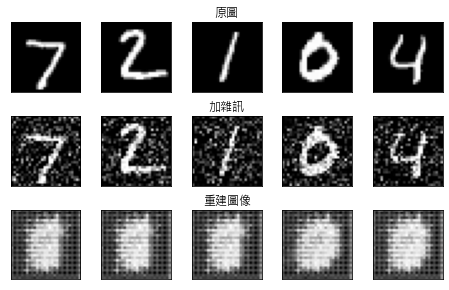

EPOCH 2/50 	 訓練損失：97818.211 	 驗證損失： 2962813.750


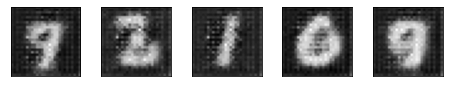

EPOCH 3/50 	 訓練損失：92717.203 	 驗證損失： 2693466.250


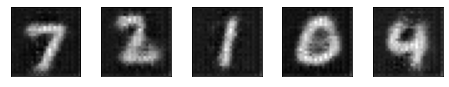

EPOCH 4/50 	 訓練損失：91067.617 	 驗證損失： 2582976.000


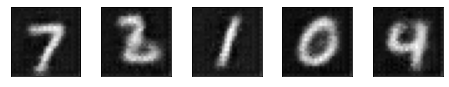

EPOCH 5/50 	 訓練損失：90404.492 	 驗證損失： 2552382.250


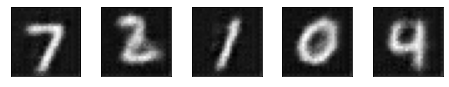

EPOCH 6/50 	 訓練損失：90046.773 	 驗證損失： 2525789.250


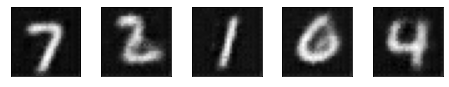

EPOCH 7/50 	 訓練損失：89865.266 	 驗證損失： 2519283.250


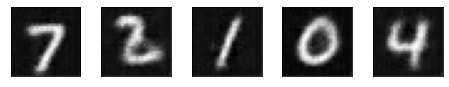

EPOCH 8/50 	 訓練損失：89695.578 	 驗證損失： 2501479.250


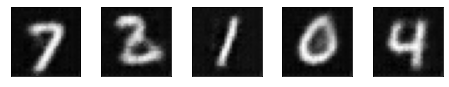

EPOCH 9/50 	 訓練損失：89593.477 	 驗證損失： 2484033.000


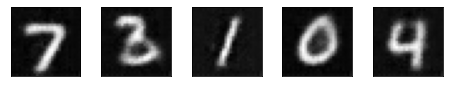

EPOCH 10/50 	 訓練損失：89468.555 	 驗證損失： 2484613.750


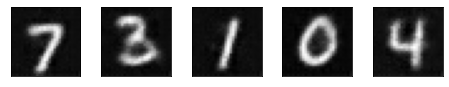

EPOCH 11/50 	 訓練損失：89387.523 	 驗證損失： 2473804.250


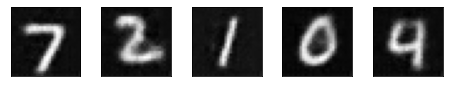

EPOCH 12/50 	 訓練損失：89332.859 	 驗證損失： 2466890.000


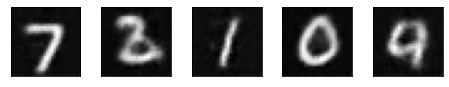

EPOCH 13/50 	 訓練損失：89303.273 	 驗證損失： 2471164.000


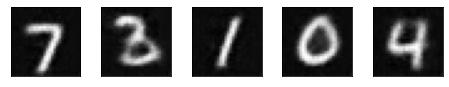

EPOCH 14/50 	 訓練損失：89245.031 	 驗證損失： 2465794.750


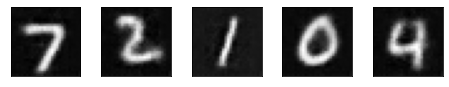

EPOCH 15/50 	 訓練損失：89204.977 	 驗證損失： 2457238.500


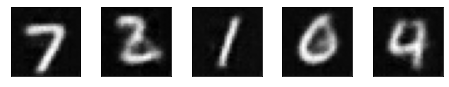

EPOCH 16/50 	 訓練損失：89180.742 	 驗證損失： 2468456.250


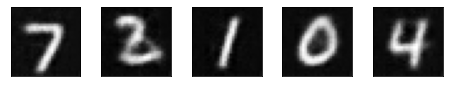

EPOCH 17/50 	 訓練損失：89132.609 	 驗證損失： 2456673.750


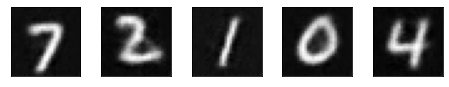

EPOCH 18/50 	 訓練損失：89075.469 	 驗證損失： 2443665.750


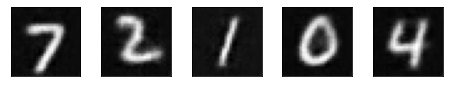

EPOCH 19/50 	 訓練損失：89059.344 	 驗證損失： 2447153.000


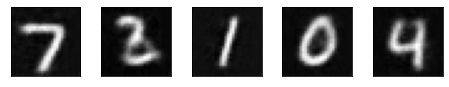

EPOCH 20/50 	 訓練損失：89018.000 	 驗證損失： 2444519.000


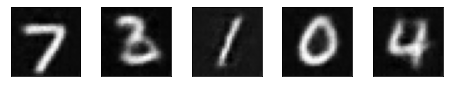

EPOCH 21/50 	 訓練損失：89013.523 	 驗證損失： 2434033.000


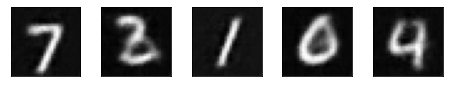

EPOCH 22/50 	 訓練損失：88990.023 	 驗證損失： 2436424.750


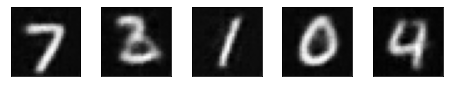

EPOCH 23/50 	 訓練損失：88990.992 	 驗證損失： 2428233.250


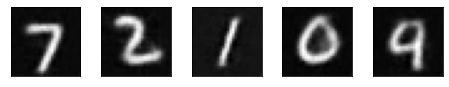

EPOCH 24/50 	 訓練損失：88960.898 	 驗證損失： 2451662.000


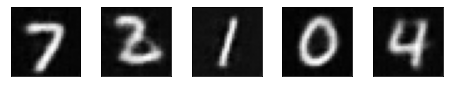

EPOCH 25/50 	 訓練損失：88935.594 	 驗證損失： 2435227.000


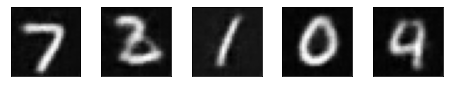

EPOCH 26/50 	 訓練損失：88904.914 	 驗證損失： 2443810.750


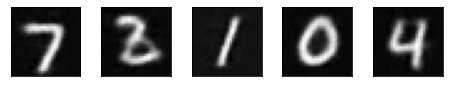

EPOCH 27/50 	 訓練損失：88889.773 	 驗證損失： 2434051.000


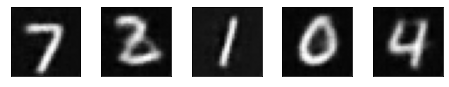

EPOCH 28/50 	 訓練損失：88891.805 	 驗證損失： 2433345.000


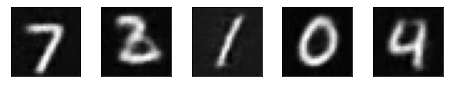

EPOCH 29/50 	 訓練損失：88870.688 	 驗證損失： 2427855.250


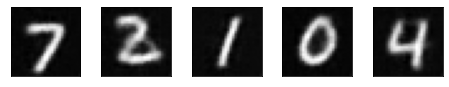

EPOCH 30/50 	 訓練損失：88847.289 	 驗證損失： 2435038.500


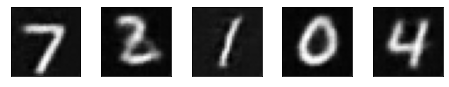

EPOCH 31/50 	 訓練損失：88828.828 	 驗證損失： 2429903.000


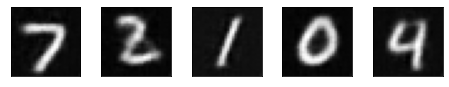

EPOCH 32/50 	 訓練損失：88833.508 	 驗證損失： 2426667.250


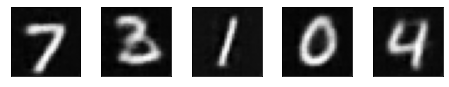

EPOCH 33/50 	 訓練損失：88827.391 	 驗證損失： 2420825.750


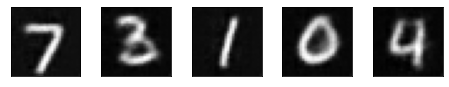

EPOCH 34/50 	 訓練損失：88775.633 	 驗證損失： 2430612.750


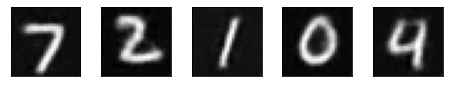

EPOCH 35/50 	 訓練損失：88801.430 	 驗證損失： 2431657.750


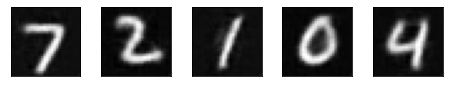

EPOCH 36/50 	 訓練損失：88764.055 	 驗證損失： 2430106.500


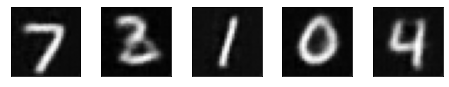

EPOCH 37/50 	 訓練損失：88760.570 	 驗證損失： 2418026.250


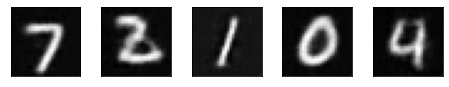

EPOCH 38/50 	 訓練損失：88766.695 	 驗證損失： 2428936.000


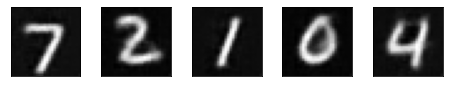

EPOCH 39/50 	 訓練損失：88763.680 	 驗證損失： 2429852.500


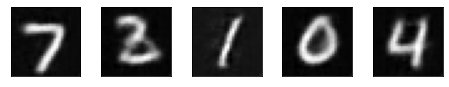

EPOCH 40/50 	 訓練損失：88750.070 	 驗證損失： 2425745.250


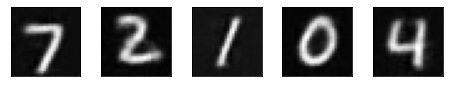

EPOCH 41/50 	 訓練損失：88721.922 	 驗證損失： 2423139.250


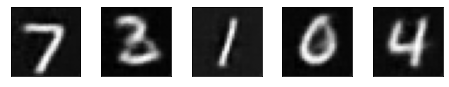

EPOCH 42/50 	 訓練損失：88747.742 	 驗證損失： 2429310.250


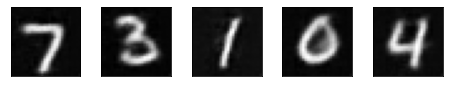

EPOCH 43/50 	 訓練損失：88711.242 	 驗證損失： 2420494.500


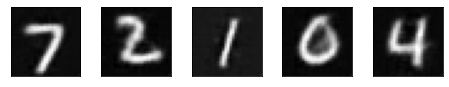

EPOCH 44/50 	 訓練損失：88718.875 	 驗證損失： 2429284.000


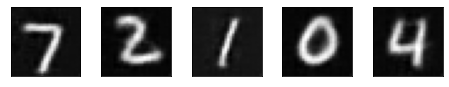

EPOCH 45/50 	 訓練損失：88696.414 	 驗證損失： 2422137.000


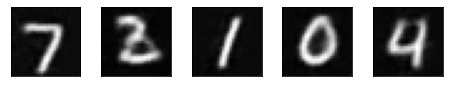

EPOCH 46/50 	 訓練損失：88697.305 	 驗證損失： 2423850.000


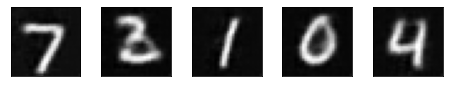

EPOCH 47/50 	 訓練損失：88673.578 	 驗證損失： 2420209.000


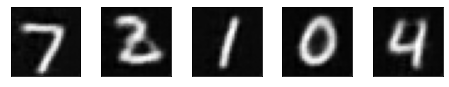

EPOCH 48/50 	 訓練損失：88668.922 	 驗證損失： 2425758.500


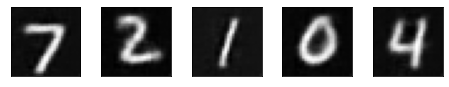

EPOCH 49/50 	 訓練損失：88675.695 	 驗證損失： 2416296.750


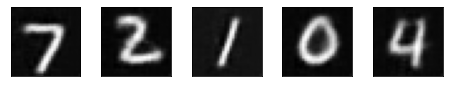

EPOCH 50/50 	 訓練損失：88662.539 	 驗證損失： 2415845.750


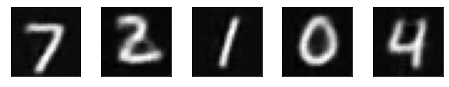

In [18]:
noise_factor = 0.3
num_epochs = 50
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    # print(f'EPOCH {epoch + 1}/{num_epochs}')
    # 訓練
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    # 驗證
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    # Print Validation loss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print(f'EPOCH {epoch + 1}/{num_epochs} \t 訓練損失：{train_loss:.3f}' + 
          f' \t 驗證損失： {val_loss:.3f}')
    plot_ae_outputs_den(epoch,encoder,decoder,noise_factor=noise_factor)

In [19]:
test_epoch_den(encoder,decoder,device,test_loader,loss_fn).item()

2008694.25

## 使用隨機亂數生成圖像

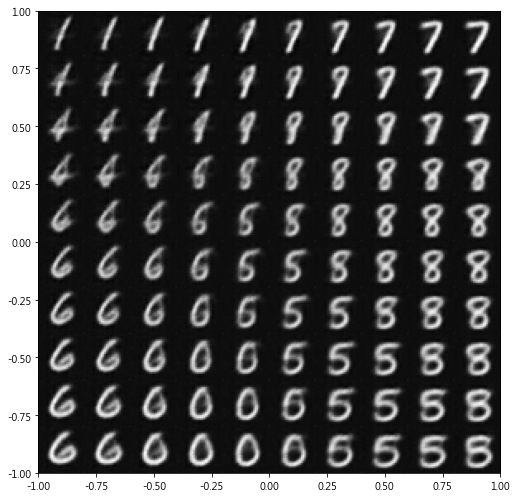

In [20]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    # 隨機亂數
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y], [x, y]]).reshape(-1,4).to(device)
            # print(z.shape)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

plot_reconstructed(decoder, r0=(-1, 1), r1=(-1, 1))

## 觀察模型中間的潛在因子(Latent Factor)，即編碼器的輸出

In [21]:
encoded_samples = []
for sample in test_ds:
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = resample(*encoder(img))
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"變數 {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,變數 0,變數 1,變數 2,變數 3,label
0,2.246607,0.805151,1.385381,2.004819,7
1,-1.333941,-1.754945,1.553671,0.478093,2
2,-0.845387,1.076846,-0.028885,1.378764,1
3,-0.496653,-0.742359,-0.532830,-1.362985,0
4,0.800854,-0.318163,-2.056818,-0.452218,4
...,...,...,...,...,...
9995,-0.975886,0.742594,3.093884,0.625953,2
9996,-0.913054,-1.356042,1.036361,-0.019084,3
9997,0.473017,1.283741,-1.697238,0.724151,4
9998,-0.085679,0.895771,-0.647705,-0.625381,5


In [22]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(encoded_samples, x='變數 0', y='變數 1', 
                 color=encoded_samples.label.astype(str), opacity=0.7)
fig_widget = go.FigureWidget(fig)
fig_widget

FigureWidget({
    'data': [{'hovertemplate': 'color=7<br>變數 0=%{x}<br>變數 1=%{y}<extra></extra>',
            …

## TSNE 降維

In [23]:
# TSNE 降維
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

# 繪圖
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str)
                 ,labels={'0': 'tsne-變數1', '1': 'tsne-變數2'})
fig_widget = go.FigureWidget(fig)
fig_widget

f:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

f:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



FigureWidget({
    'data': [{'hovertemplate': 'color=7<br>tsne-變數1=%{x}<br>tsne-變數2=%{y}<extra></extra>',
    …